<h1>******************************Imports*********************************** </h1>

In [1]:
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from langsmith import traceable
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from typing import TypedDict, Literal,Annotated
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder
from trustcall import create_extractor
import uuid
from IPython.display import Image, display

from datetime import datetime
from trustcall import create_extractor
from typing import Optional
from pydantic import BaseModel, Field
from langgraph.store.base import BaseStore

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import merge_message_runs, HumanMessage, SystemMessage

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, END, START
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langchain_core.runnables import RunnableConfig
import os

In [2]:
os.environ["LANGSMITH_PROJECT"] = "task_mAistro"

In [3]:
def printer(node,key,value):
    print("\n",node,":",key,"\n",value,"\n")

<h1>******************************model*********************************** </h1>

In [4]:
load_dotenv()
api_key = os.getenv("OPENAI_API_KEY")

llm = ChatOpenAI(
    model_name="gpt-4o-mini",   
    openai_api_key=api_key,
    max_tokens=500             
)

<h1>********************* spy for trust call excutor with listner ********************</h1>

In [5]:
# Inspect the tool calls made by Trustcall
class Spy:
    def __init__(self):
        self.called_tools = []

    def __call__(self, run):
        # Collect information about the tool calls made by the extractor.
        q = [run]
        while q:
            r = q.pop()
            if r.child_runs:
                q.extend(r.child_runs)
            if r.run_type == "chat_model":
                self.called_tools.append(
                    r.outputs["generations"][0][0]["message"]["kwargs"]["tool_calls"]
                )

# Initialize the spy
spy = Spy()

In [6]:
def extract_tool_info(tool_calls, schema_name="Memory"):
    """Extract information from tool calls for both patches and new memories.
    
    Args:
        tool_calls: List of tool calls from the model
        schema_name: Name of the schema tool (e.g., "Memory", "ToDo", "Profile")
    """

    # Initialize list of changes
    changes = []
    
    for call_group in tool_calls:
        for call in call_group:
            if call['name'] == 'PatchDoc':
                changes.append({
                    'type': 'update',
                    'doc_id': call['args']['json_doc_id'],
                    'planned_edits': call['args']['planned_edits'],
                    'value': call['args']['patches'][0]['value']
                })
            elif call['name'] == schema_name:
                changes.append({
                    'type': 'new',
                    'value': call['args']
                })

    # Format results as a single string
    result_parts = []
    for change in changes:
        if change['type'] == 'update':
            result_parts.append(
                f"Document {change['doc_id']} updated:\n"
                f"Plan: {change['planned_edits']}\n"
                f"Added content: {change['value']}"
            )
        else:
            result_parts.append(
                f"New {schema_name} created:\n"
                f"Content: {change['value']}"
            )
    
    return "\n\n".join(result_parts)

# Inspect spy.called_tools to see exactly what happened during the extraction
# schema_name = "Memory"
# changes = extract_tool_info(spy.called_tools, schema_name)
# print(changes)

<h1> 1. descison maker agent</h1>

In [7]:
MODEL_SYSTEM_MESSAGE = """You are a helpful chatbot. 

You are designed to be a companion to a user, helping them keep track of their ToDo list.

You have a long term memory which keeps track of three things:
1. The user's profile (general information about them) 
2. The user's ToDo list
3. General instructions for updating the ToDo list

Here is the current User Profile (may be empty if no information has been collected yet):
<user_profile>
{user_profile}
</user_profile>

Here is the current ToDo List (may be empty if no tasks have been added yet):
<todo>
{todo}
</todo>

Here are the current user-specified preferences for updating the ToDo list (may be empty if no preferences have been specified yet):
<instructions>
{instructions}
</instructions>

Here are your instructions for reasoning about the user's messages:

1. Reason carefully about the user's messages as presented below. 

2. Decide whether any of the your long-term memory should be updated:
- If personal information was provided about the user, update the user's profile by calling UpdateMemory tool with type `user`
- If tasks are mentioned, update the ToDo list by calling UpdateMemory tool with type `todo`
- If the user has specified preferences for how to update the ToDo list, update the instructions by calling UpdateMemory tool with type `instructions`

3. Tell the user that you have updated your memory, if appropriate:
- Do not tell the user you have updated the user's profile
- Tell the user them when you update the todo list
- Do not tell the user that you have updated instructions

4. Err on the side of updating the todo list. No need to ask for explicit permission.

5. Respond naturally to user user after a tool call was made to save memories, or if no tool call was made."""

In [8]:
class UpdateMemory(TypedDict):
    """based on the information decide which memory to update"""
    update_type = Annotated[Literal['user', 'todo', 'instructions'], "These are the values you have to choose form these only"]

In [9]:
decision_maker_llm = llm.bind_tools([UpdateMemory],parallel_tool_calls=False)

<p style="color: red; text-align: center; size:16px>2. todo node</p>


In [10]:
def task_mAIstro(state:MessagesState, config:RunnableConfig, store:BaseStore):

    print("******************************* Task_mAIstro **************************************")

    user_id = config["configurable"]["user_id"]

    ns_profile = ("profile",user_id)
    ns_todo = ("todo",user_id)
    ns_instructions = ("instructions", user_id)


    profile_data = store.search(ns_profile)
    todo_data = store.search(ns_todo)
    instructions_data = store.search(ns_instructions)

    if profile_data:
        profile = profile_data[0].value
    else:
        profile = None

    if instructions_data:
        instructions = instructions_data[0].value
    else:
        instructions = None

    todo = "\n".join(f"{mem.value}" for mem in todo_data)
 
    template = ChatPromptTemplate.from_messages([
    ("system",MODEL_SYSTEM_MESSAGE ),
    ])

    temp = template.format_messages(
        user_profile=profile, todo=todo, instructions=instructions
    )
    
    response = decision_maker_llm.invoke(temp + state['messages'])

    return {"messages":[response]}
    

In [11]:
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore) -> Literal[END, "update_todos", "todo_update_instructions", "update_profile"]:
    
    message = state['messages'][-1]
    
    if len(message.tool_calls) ==0:
        return END
    else:
        tool_call = message.tool_calls[0]
        print(tool_call)
        
        if tool_call['args']['type'] == "user":
            return "update_profile"
        elif tool_call['args']['type'] == "todo":
            return "update_todos"
        elif tool_call['args']['type'] == "instructions":
            return "todo_update_instructions"
        else:
            raise ValueError

In [12]:
TRUSTCALL_INSTRUCTION = """Reflect on following interaction. 

Use the provided tools to retain any necessary memories about the user. 

Use parallel tool calling to handle updates and insertions simultaneously.

System Time: {time}"""


class Profile(BaseModel):
    """This is the profile of the user you are chatting with"""
    name: Optional[str] = Field(description="The user's name", default=None)
    location: Optional[str] = Field(description="The user's location", default=None)
    job: Optional[str] = Field(description="The user's job", default=None)
    connections: list[str] = Field(
        description="Personal connection of the user, such as family members, friends, or coworkers",
        default_factory=list
    )
    interests: list[str] = Field(
        description="Interests that the user has", 
        default_factory=list
    )

profile_extractor = create_extractor(
    llm,
    tools=[Profile],
    tool_choice="Profile",
)


def update_profile(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    print("******************************* update_profile **************************************")
    
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("profile", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Profile"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Invoke the extractor
    result = profile_extractor.invoke({"messages": updated_messages, 
                                         "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated profile", "tool_call_id":tool_calls[0]['id']}]}

In [13]:
class ToDo(BaseModel):
    task: str = Field(description="The task to be completed.")
    time_to_complete: Optional[int] = Field(description="Estimated time to complete the task (minutes).")
    deadline: Optional[datetime] = Field(
        description="When the task needs to be completed by (if applicable)",
        default=None
    )
    solutions: list[str] = Field(
        description="List of specific, actionable solutions (e.g., specific ideas, service providers, or concrete options relevant to completing the task)",
        min_items=1,
        default_factory=list
    )
    status: Literal["not started", "in progress", "done", "archived"] = Field(
        description="Current status of the task",
        default="not started"
    )


def update_todos(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    print("******************************* update_todos **************************************")
    
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("todo", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "ToDo"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Merge the chat history and the instruction
    TRUSTCALL_INSTRUCTION_FORMATTED=TRUSTCALL_INSTRUCTION.format(time=datetime.now().isoformat())
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=TRUSTCALL_INSTRUCTION_FORMATTED)] + state["messages"][:-1]))

    # Initialize the spy for visibility into the tool calls made by Trustcall
    spy = Spy()
    
    # Create the Trustcall extractor for updating the ToDo list 
    todo_extractor = create_extractor(
    llm,
    tools=[ToDo],
    tool_choice=tool_name,
    enable_inserts=True
    ).with_listeners(on_end=spy)

    # Invoke the extractor
    result = todo_extractor.invoke({"messages": updated_messages, 
                                    "existing": existing_memories})

    # Save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )
        
    # Respond to the tool call made in task_mAIstro, confirming the update
    tool_calls = state['messages'][-1].tool_calls

    # Extract the changes made by Trustcall and add the the ToolMessage returned to task_mAIstro
    todo_update_msg = extract_tool_info(spy.called_tools, tool_name)
    return {"messages": [{"role": "tool", "content": todo_update_msg, "tool_call_id":tool_calls[0]['id']}]}

In [14]:
CREATE_INSTRUCTIONS = """Reflect on the following interaction.

Based on this interaction, update your instructions for how to update ToDo list items. 

Use any feedback from the user to update how they like to have items added, etc.

Your current instructions are:

<current_instructions>
{current_instructions}
</current_instructions>"""


def todo_update_instructions(state: MessagesState, config: RunnableConfig, store: BaseStore):
    
    print("******************************* update_instructions **************************************")
    
    user_id = config["configurable"]["user_id"]
    
    namespace = ("instructions", user_id)

    existing_memory = store.get(namespace, "user_instructions")
        
    # Format the memory in the system prompt
    system_msg = CREATE_INSTRUCTIONS.format(current_instructions=existing_memory.value if existing_memory else None)
    new_memory = llm.invoke([SystemMessage(content=system_msg)]+state['messages'][:-1] + [HumanMessage(content="Please update the instructions based on the conversation")])

    # Overwrite the existing memory in the store 
    key = "user_instructions"
    store.put(namespace, key, {"memory": new_memory.content})
    tool_calls = state['messages'][-1].tool_calls
    return {"messages": [{"role": "tool", "content": "updated instructions", "tool_call_id":tool_calls[0]['id']}]}

In [29]:
# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(task_mAIstro)
builder.add_node(update_todos)
builder.add_node(update_profile)
builder.add_node(todo_update_instructions)
builder.add_edge(START, "task_mAIstro")
builder.add_conditional_edges("task_mAIstro", route_message)
builder.add_edge("update_todos", "task_mAIstro")
builder.add_edge("update_profile", "task_mAIstro")
builder.add_edge("todo_update_instructions", "task_mAIstro")

across_thread_memory = InMemoryStore()

within_thread_memory = MemorySaver()

graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

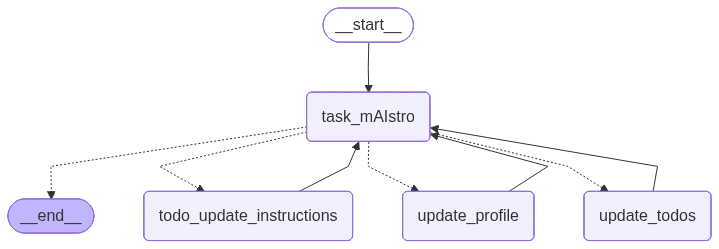

In [30]:
graph

In [31]:
config = {"configurable": {"thread_id": "1", "user_id": "zaid"}}

In [32]:
result = graph.invoke({"messages":"my name is zaid"} ,config)

******************************* Task_mAIstro **************************************
{'name': 'UpdateMemory', 'args': {'type': 'user'}, 'id': 'call_sHmZ3RZsH6wBaZkHwuzSWEZK', 'type': 'tool_call'}
******************************* update_profile **************************************
******************************* Task_mAIstro **************************************


In [33]:
for message in result["messages"]:
    message.pretty_print()

================================ Human Message =================================

my name is zaid
================================== Ai Message ==================================
Tool Calls:
  UpdateMemory (call_sHmZ3RZsH6wBaZkHwuzSWEZK)
 Call ID: call_sHmZ3RZsH6wBaZkHwuzSWEZK
  Args:
    type: user
================================= Tool Message =================================

updated profile
================================== Ai Message ==================================

Got it, Zaid! If you have anything you want to add or if there are tasks you need help with, just let me know!
